In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [8]:
def create_dataset(dataset_size):
    '''
    Function to create dataset for multi label classification by horizontally stacking two images.
    Parameters:
            dataset_size = size of the dataset to be created
    Returns : New dataset with two classes in one image and size of the returned dataset will not match with dataset_size variable, since we drop few images.
    '''
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x = np.concatenate((x_train, x_test), axis = 0) #contatenating both train and test dataset to create one large dataset.
    y = np.concatenate((y_train, y_test))
    print('Shape of the dataset after concatinating:')
    print(x.shape, y.shape)

    x_new = []
    y_new = []
    no_of_removes = 0
    for _ in range(dataset_size):
        indices = np.random.randint(0, 70000, size = 2) #randomly selecting two indices for stacking.

        ans1, ans2 = y[indices[0]], y[indices[1]]

        if ans1 == ans2:  # check if both the images have same target, if yes then skip that example and donot add it to the dataset. Although this
            # should not effect the model's performance but still for sanity check.
            no_of_removes +=1
            pass
        else:
            new_image = np.concatenate((x[indices[0]], x[indices[1]]), axis = 1)
            x_new.append(new_image)


            # new_y = [1 if z == ans1 or z == ans2 else 0 for z in range(10)]
            y_new.append((ans1, ans2))

    print(f'No of examples removed from dataset: {no_of_removes}')
    return x_new, y_new

In [9]:
dataset_size = 20000
x, y = create_dataset(dataset_size)

Shape of the dataset after concatinating:
(70000, 28, 28) (70000,)
No of examples removed from dataset: 1986


(3, 5)


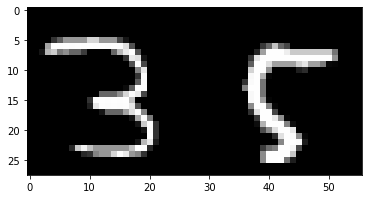

In [11]:
random = np.random.randint(dataset_size)
plt.imshow(x[random], cmap = 'gray')
print(y[random])

In [12]:
def ml_split(x, y):
    '''
    Multi hot encode the target variable and divide the data into train, validation and test data.
    '''
    # ml = MultiLabelBinarizer()
    # y = ml.fit_transform(y)

    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    ml = MultiLabelBinarizer()
    y_train = ml.fit_transform(y_train)
    y_valid = ml.transform(y_valid)
    y_test = ml.transform(y_test)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [13]:
X_train, y_train, X_valid, y_valid, X_test, y_test = ml_split(x, y)

In [14]:
def print_shapes():
    print('Shapes of dataset:')
    print('Training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nValidation dataset:')
    print(X_valid.shape, y_valid.shape)
    print('\nTesting dataset:')
    print(X_test.shape, y_test.shape)

In [15]:
def format_input(features, labels):
    '''
    convert the numpy array (images), labels to tensor objects for training, add the channel dimension to the images.
    '''
    features = tf.convert_to_tensor(features)
    features = tf.expand_dims(features, axis = -1)

    labels = tf.convert_to_tensor(labels)

    return features, labels

In [16]:
X_train, y_train = format_input(X_train, y_train)
X_valid, y_valid = format_input(X_valid, y_valid)
X_test, y_test = format_input(X_test, y_test)

print_shapes()

Shapes of dataset:
Training dataset:
(11528, 28, 56, 1) (11528, 10)

Validation dataset:
(3603, 28, 56, 1) (3603, 10)

Testing dataset:
(2883, 28, 56, 1) (2883, 10)


In [17]:
def create_generator(bath_size):
    '''
    Creating generators for augmenting (none is mentioned right now), reshaping the data and for easy flow of data to the model.
    '''
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0, dtype = 'float')

    valid_datagen = ImageDataGenerator(rescale = 1.0/255., dtype = 'float')

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True, seed = 42)
    valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size, seed = 42)
    test_generator = valid_datagen.flow(X_test, y_test, batch_size=batch_size, seed = 42)

    return train_generator, valid_generator, test_generator

In [18]:
batch_size = 128
train_generator, valid_generator, test_generator = create_generator(batch_size)

In [19]:
# define cnn model
def define_model(shape=(28, 56, 1), num_classes=10):
    '''
    Function to create model.
    '''
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    model.add(Flatten())
    # model.add(Dense(512, kernel_initializer='he_uniform'))
    # model.add(Activation('relu'))
    # model.add(Dense(256, kernel_initializer='he_uniform'))
    # model.add(Activation('relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

model = define_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 56, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 56, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 56, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 28, 32)       0         
 )                                                               
                                                                 
 activation_1 (Activation)   (None, 14, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 28, 64)        18496     
                                                        

In [21]:
plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [22]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.75):
            print("\nReached 75% accuracy so cancelling training!")
            self.model.stop_training = True

es = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 25, verbose = 1, restore_best_weights=True,
                                      min_delta = 0.02)
callbacks = myCallback()

In [23]:
opt = tf.keras.optimizers.RMSprop()
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [26]:
epochs = 10

hist = model.fit(train_generator, epochs = epochs, validation_data = valid_generator, callbacks=[callbacks])

Epoch 1/10
91/91 [==============================] - 70s 764ms/step - loss: 0.0087 - accuracy: 0.5424 - val_loss: 0.0276 - val_accuracy: 0.5212
Epoch 2/10
91/91 [==============================] - 69s 758ms/step - loss: 0.0075 - accuracy: 0.5363 - val_loss: 0.0186 - val_accuracy: 0.5609
Epoch 3/10
91/91 [==============================] - 69s 758ms/step - loss: 0.0069 - accuracy: 0.5429 - val_loss: 0.0160 - val_accuracy: 0.5268
Epoch 4/10
91/91 [==============================] - 69s 761ms/step - loss: 0.0074 - accuracy: 0.5235 - val_loss: 0.0153 - val_accuracy: 0.5035
Epoch 5/10
91/91 [==============================] - 69s 760ms/step - loss: 0.0058 - accuracy: 0.5340 - val_loss: 0.0203 - val_accuracy: 0.6037
Epoch 6/10
91/91 [==============================] - 69s 763ms/step - loss: 0.0076 - accuracy: 0.5481 - val_loss: 0.0242 - val_accuracy: 0.5920
Epoch 7/10
91/91 [==============================] - 69s 762ms/step - loss: 0.0069 - accuracy: 0.5111 - val_loss: 0.0167 - val_accuracy: 0.4693

In [27]:
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']

valid_acc = hist.history['val_accuracy']
valid_loss = hist.history['val_loss']
epochs = range(len(train_acc))

Text(0.5, 1.0, 'Accuracy')

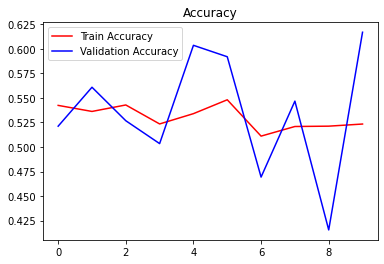

In [28]:
plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

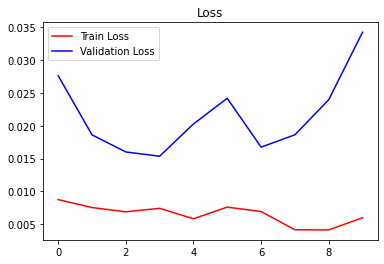

In [29]:
plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
plt.legend()
plt.title('Loss')

In [30]:
loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
print(loss)
print(int(accuracy * 100), '%')

23/23 [==============================] - 3s 124ms/step - loss: 0.0399 - accuracy: 0.5900
0.039891865104436874
59 %


In [31]:
model.save('mnist-2-2.h5')